In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis


## interactive plots with pyvis

In [2]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

#remove subthalamus
cols_to_keep = [col for col in controls.columns if 'Subthal' not in col]
controls = controls[cols_to_keep]
preterms = preterms[cols_to_keep]


### first get all regions pairs, metrics to be evaluated 
tract_names = np.unique(np.array([tract.split('_')[0] for tract in controls.columns[2:]]))
print('Number of evaluated bundles: {}'.format(len(tract_names)))
metrics = np.unique(np.array([tract.partition('_')[-1] for tract in controls.columns[2:]]))

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#sanity check: 
if len(preterms) == len(matched):
    print('Number of subject pairs: {}'.format(len(preterms)))
else:
    print('Someting happened with matching')
    
# get age at birth info for the subgrouping
ages = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')

matched['preterm_birth_age'] = 0.
matched['control_birth_age'] = 0.
for i, row in matched.iterrows():
    matched.at[i, 'preterm_birth_age']  = ages[ages['participant_id '] == row['preterm_ID']+' ']['birth_age '].values[0]
    matched.at[i, 'control_birth_age']  = ages[ages['participant_id '] == row['matched_ID_with_outcome']+' ']['birth_age '].values[0]
 

controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]

Number of evaluated bundles: 18
Number of subject pairs: 59


In [3]:
#extreme_pairs = matched[matched.preterm_birth_age < 32][['preterm_ID','matched_ID_with_outcome']]

#preterms = preterms[preterms.subject_id.isin(extreme_pairs.preterm_ID.values)]
#controls = controls[controls.subject_id.isin(extreme_pairs.matched_ID_with_outcome.values)]

In [4]:
set1 = ['AD','RD', 'FA']
#et1 = ['AD', 'RD', 'FA', 'MD','NDI_post', 'ODI_post' ]
set2 = ['FA', 'MD']
set3 = ['NDI_post', 'ODI_post']
set4 = ['NDI_pre', 'ODI_pre']


df_dist = pd.DataFrame()
df_dist['subject_id'] = preterms.subject_id

for tract in tract_names:
    
    features = np.array([tract+'_'+metric for metric in set1])
    
    control_ar = controls[features].values
    ## normalize by mean 
    mean_control = np.mean(control_ar, axis=0)
    range_control = np.ptp(control_ar, axis=0)
    #std_control = np.std(control_ar, axis=0)
    control_ar = (control_ar / mean_control) #/ range_control
   
    ## get inverse covariance matrix for the control group 
    corr = np.cov(control_ar.T)
    corrI = np.linalg.inv(corr)
    
    distances = []
    
    for i, row in preterms.iterrows():
        subj_vect = row[features].values
        subj_vect = (subj_vect / mean_control)# / range_control
        cont_vect = np.mean(control_ar, axis=0) 
        #cont_vect = np.ones_like(subj_vect)
        
        #print(subj_vect)
        mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
        
        #mh = np.sqrt(np.dot(np.dot((subj_vect - cont_vect).T,corrI), (subj_vect - cont_vect)))
        #print(mh)
        
        distances.append(row[features[0]])
        #distances.append(mh)
         
        
    df_dist[tract] = np.array(distances)
    
          

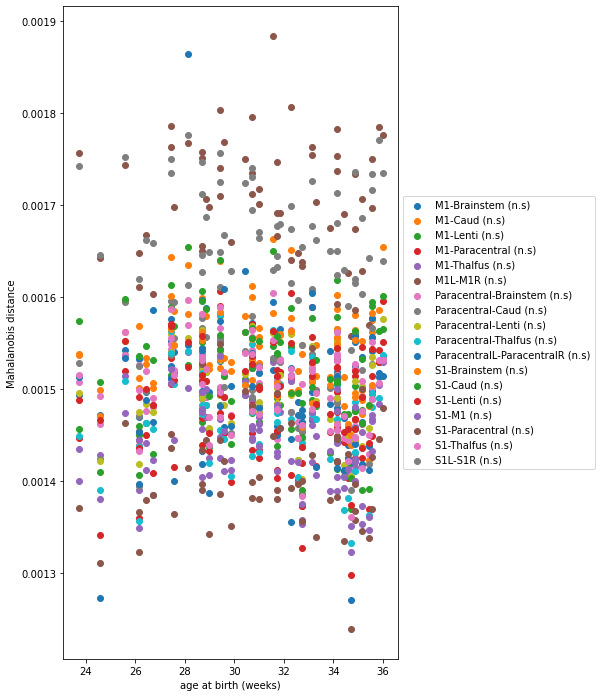

In [5]:
age_at_birth= [ matched[matched.preterm_ID == subj_id]['preterm_birth_age'].values[0] for subj_id in df_dist.subject_id.values]
age_at_scan = [ matched[matched.preterm_ID == subj_id]['preterm_scan_age'].values[0] for subj_id in df_dist.subject_id.values]
 
df_dist['age_at_birth'] = 0 
df_dist['age_at_scan'] = 0 
for i,row in df_dist.iterrows():
    df_dist.loc[i,'age_at_birth'] = matched[matched.preterm_ID == row.subject_id].preterm_birth_age.values
    df_dist.loc[i,'age_at_scan'] = matched[matched.preterm_ID == row.subject_id].preterm_scan_age.values
    
df_dist['age_diff'] = df_dist['age_at_scan'] - df_dist['age_at_birth']
pvals = []
for column in tract_names:
    
    #test = pg.corr(df_dist[column].values, age_at_scan, method='pearson')
    test = pg.linear_regression(df_dist[column].values, df_dist.age_at_birth.values)
    #print(test)
    p = "{:.7f}".format(test['pval'].values[1])
    pvals.append(p)
reject, pvals_corr = pg.multicomp(np.array(pvals).astype(np.float64), method='fdr_bh')
                                
labels = []
for p in pvals_corr:
    if p > 0.05:
        labels.append('(n.s)')
    else:
        labels.append('*')
        
#fig = plt.figure(figsize=(6, 12))
fig, axs = plt.subplots(1,1, figsize=(6, 12))
for column, pvalue in zip(tract_names, labels):
    
    plt.scatter(df_dist.age_at_birth.values, df_dist[column].values, label=column+' '+pvalue)
    
#for column in df_dist.columns[1:]:
#    axs[1].scatter(age_at_scan, df_dist[column].values, label=column)
    
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title('Centered', fontsize=16)
plt.xlabel('age at birth (weeks)')
plt.ylabel('Mahalanobis distance')
plt.show()

In [31]:
from itertools import combinations
pvals = []
for combination in list(combinations(df_dist.columns[1:-3].values, 2)):
    
    a = df_dist[combination[0]].values - df_dist[combination[1]].values
    ### paube I should do a paired t-test here instead?
    test = pg.ttest(a,0)
    #print(combination)
    #print(combination[0], np.mean(df_dist[combination[0]].values)*1000, combination[1], np.mean(df_dist[combination[1]].values)*1000)
    #pg.linear_regression(df_dist[combination[0]].values, df_dist[combination[1]].values)
    p = "{:.9f}".format(test['p-val'].values[0])
    pvals.append(p)
reject, pvals_corr = pg.multicomp(np.array(pvals).astype(np.float64), method='fdr_bh')

df = pd.DataFrame(columns=['region1', 'region2', 'corrected_p'])
i=0
for val, combination in zip(pvals_corr, list(combinations(df_dist.columns[1:-3].values, 2))):
    #print(combination,  "{:.5f}".format(val))
    df.loc[i, 'region1'] = combination[0]
    df.loc[i, 'region2'] = combination[1]
    df.loc[i, 'corrected_p'] = "{:.5f}".format(val)
    i = i+1
    
df['corrected_p'] = df['corrected_p'].astype(np.float64)

In [32]:
#df2 = df.pivot(index='region1', columns='region2', values='corrected_p')
#df2 = df2.rename_axis(None, axis=1).reset_index()


In [33]:
regions = [reg for reg in df.region1.values]
for reg in df.region2.values:
    regions.append(reg)
    
edges = []
weights = []

for i, row in df.iterrows():
    if row.corrected_p > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p)

In [34]:
import networkx as nx 
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


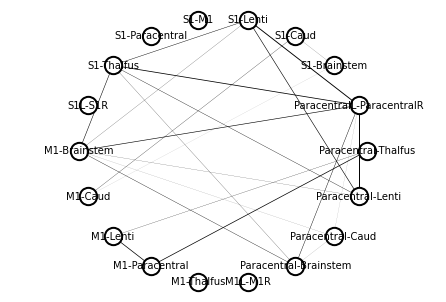

In [35]:
options = {
    'font_size': 10,
    #'node_size' : 5000,
    'node_color': 'white',
    'edgecolors' : 'black',
    'linewidths': 2,
    'width': list(weights)
}

pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels= True, **options)

x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

In [36]:
for h in nx.connected_components(G):
    print(h)

{'S1-Thalfus', 'M1-Brainstem', 'Paracentral-Brainstem', 'S1-Lenti', 'Paracentral-Lenti', 'Paracentral-Caud', 'ParacentralL-ParacentralR'}
{'S1-Brainstem', 'M1-Caud', 'S1-Caud'}
{'M1-Paracentral', 'Paracentral-Thalfus', 'M1-Lenti'}
{'M1-Thalfus'}
{'M1L-M1R'}
{'S1-M1'}
{'S1-Paracentral'}
{'S1L-S1R'}
